In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from LDMIBSS import *
from scipy import linalg
# np.random.seed(13)
%load_ext autoreload
%autoreload 2

The following is the correlation matrix of sources


<IPython.core.display.Math object>

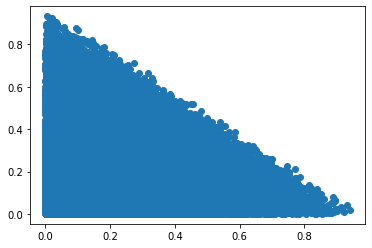

In [3]:
N = 100000
NumberofSources = 5
NumberofMixtures = 10
# first_row = [1, 0.5, 0.5, 0.5, 0.5]
# calib_correl_matrix = linalg.toeplitz(first_row, first_row)
# L = np.linalg.cholesky(calib_correl_matrix)
S = np.random.exponential(scale=1.0, size=(NumberofSources,int(N)))
# S = L @ S
S = S / np.sum(S, axis = 0)
print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))
plt.scatter(S[0,:], S[1,:])

In [4]:
np.corrcoef(S)

array([[ 1.        , -0.24781685, -0.24953611, -0.25066807, -0.25448591],
       [-0.24781685,  1.        , -0.2488306 , -0.25379379, -0.24801573],
       [-0.24953611, -0.2488306 ,  1.        , -0.2484066 , -0.24738908],
       [-0.25066807, -0.25379379, -0.2484066 ,  1.        , -0.2510337 ],
       [-0.25448591, -0.24801573, -0.24738908, -0.2510337 ,  1.        ]])

In [5]:
# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

print("The following is the mixture matrix A")
display_matrix(A)

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.999797273176622


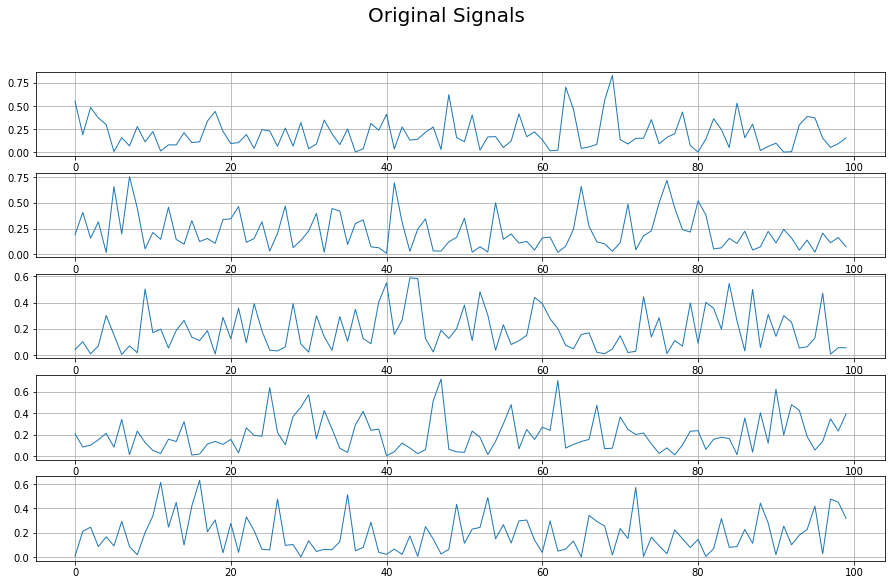

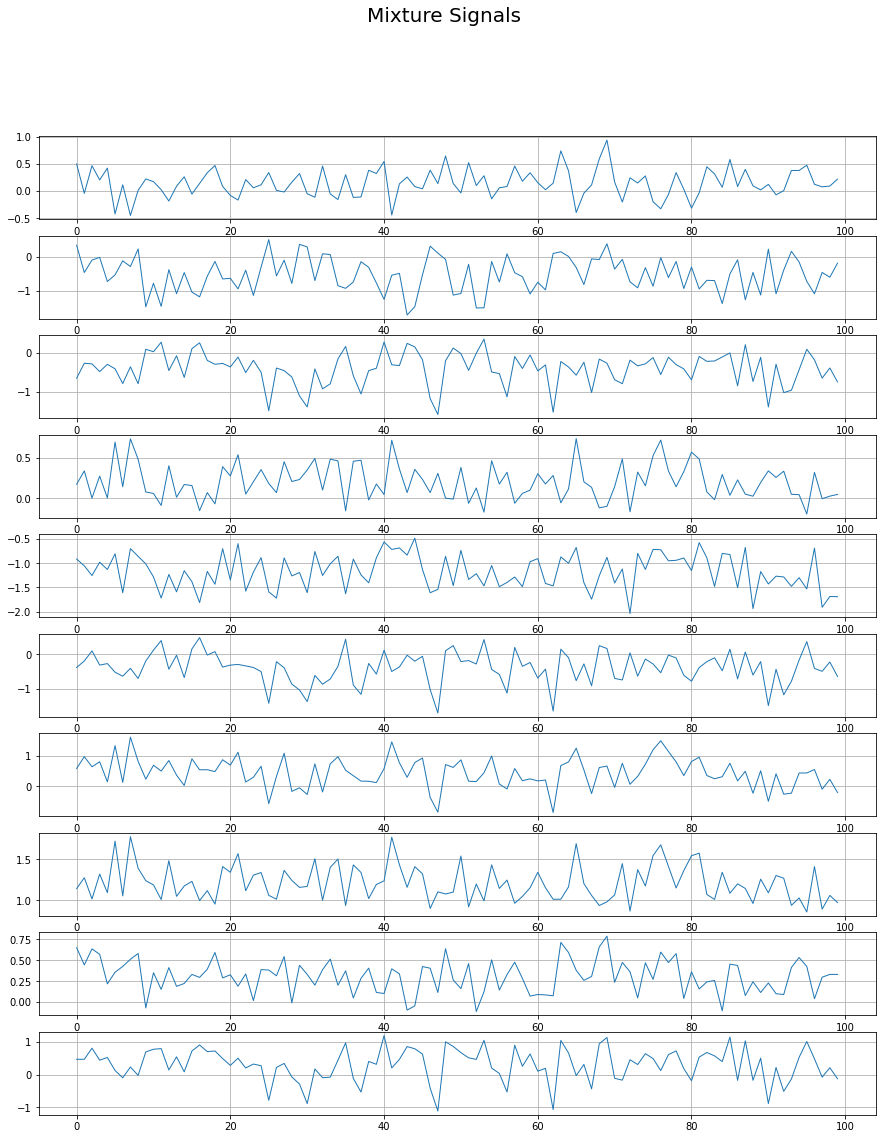

In [6]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

In [7]:
S.sum(axis = 0)

array([1., 1., 1., ..., 1., 1., 1.])

In [8]:
lambday = 1 - 1e-1/10
lambdae = 1 - 1e-1/10
s_dim = S.shape[0]
x_dim = X.shape[0]

# Inverse output covariance
By = 5 * np.eye(s_dim)
# Inverse error covariance
Be = 1000 * np.eye(s_dim)

debug_iteration_point = 1000
model = OnlineLDMIBSS(s_dim = s_dim, x_dim = x_dim, muW = 30*1e-3, lambday = lambday,
                      lambdae = lambdae, By = By, Be = Be, neural_OUTPUT_COMP_TOL = 1e-6,
                      set_ground_truth = True, S = S, A = A)

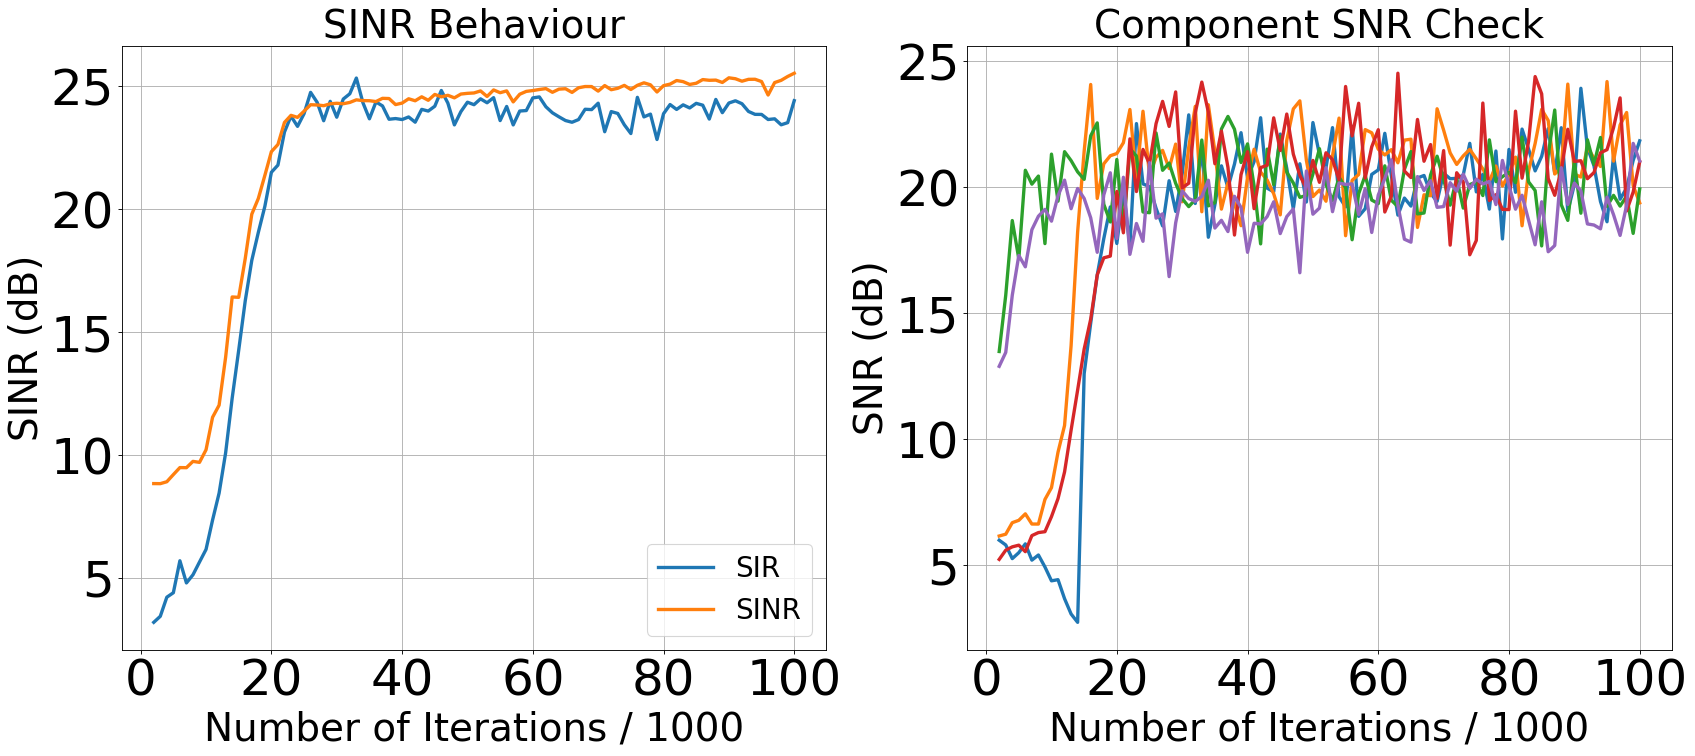

100%|█████████████████████████████████| 100000/100000 [01:24<00:00, 1190.26it/s]


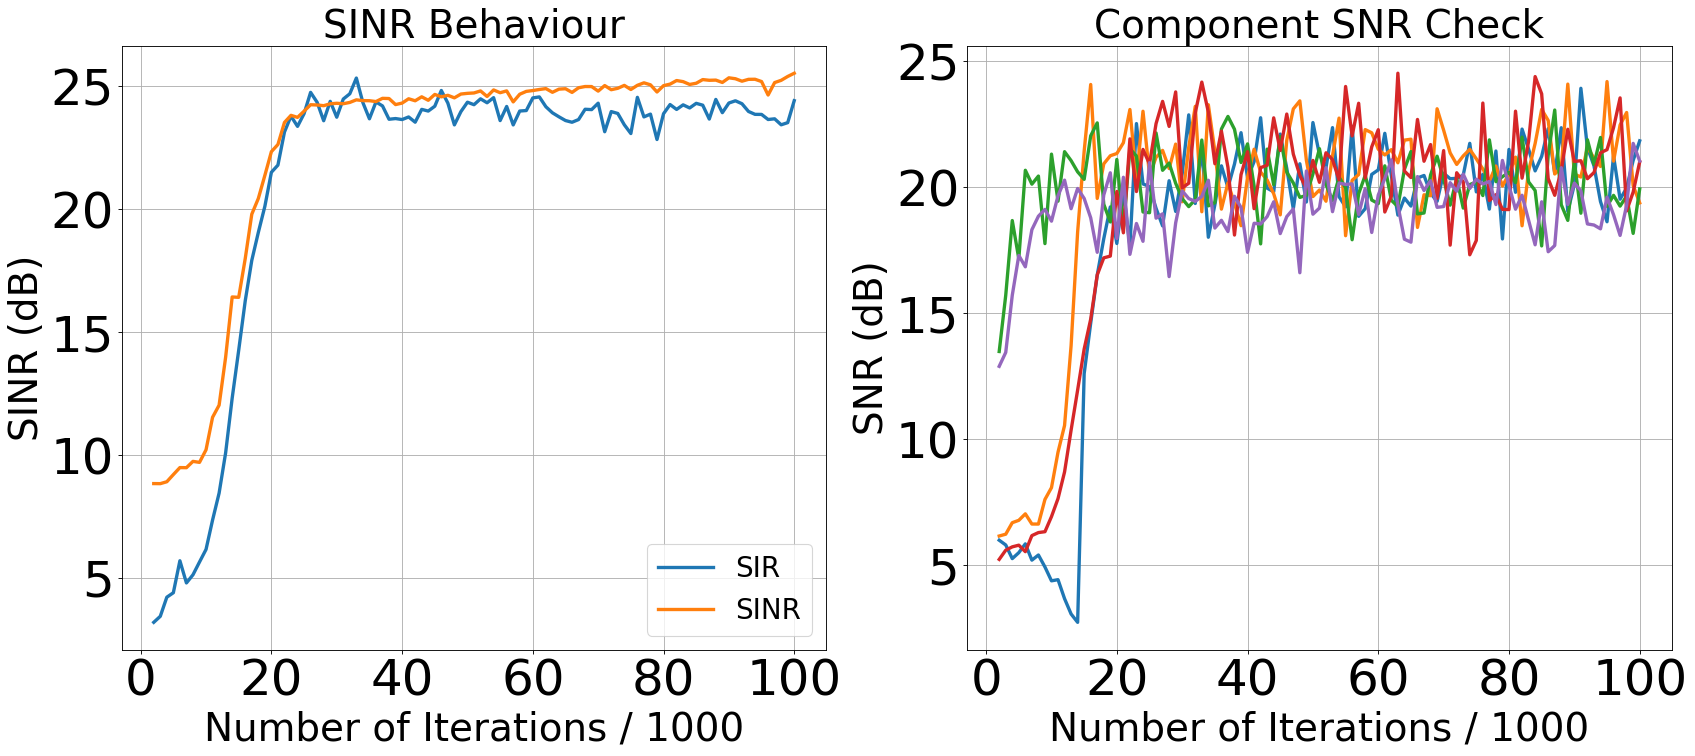

In [9]:
model.fit_batch_simplex(X = X, n_epochs = 1, neural_dynamic_iterations = 500,
                         plot_in_jupyter = True, neural_lr_start = 0.1,
                         neural_lr_stop = 0.001, debug_iteration_point = debug_iteration_point, 
                         shuffle = True)

Final SINR: 25.521908800359668


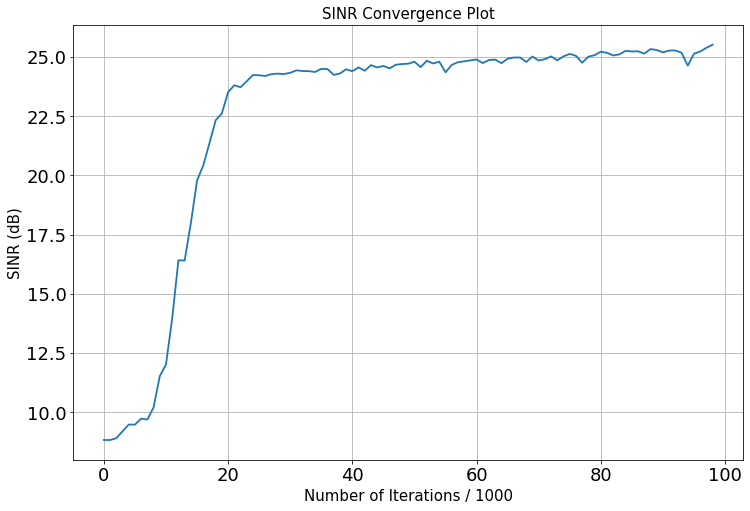

In [10]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(model.SINR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

print('Final SINR: {}'.format(np.array(model.SINR_list[-1])))

In [11]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T).T
Y_.shape, X.shape, S.shape

((5, 100000), (10, 100000), (5, 100000))

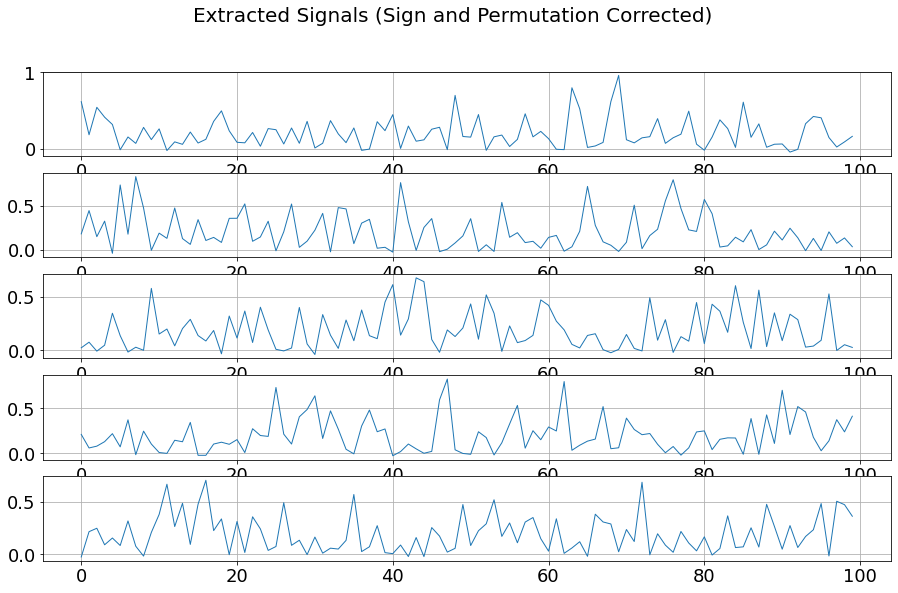

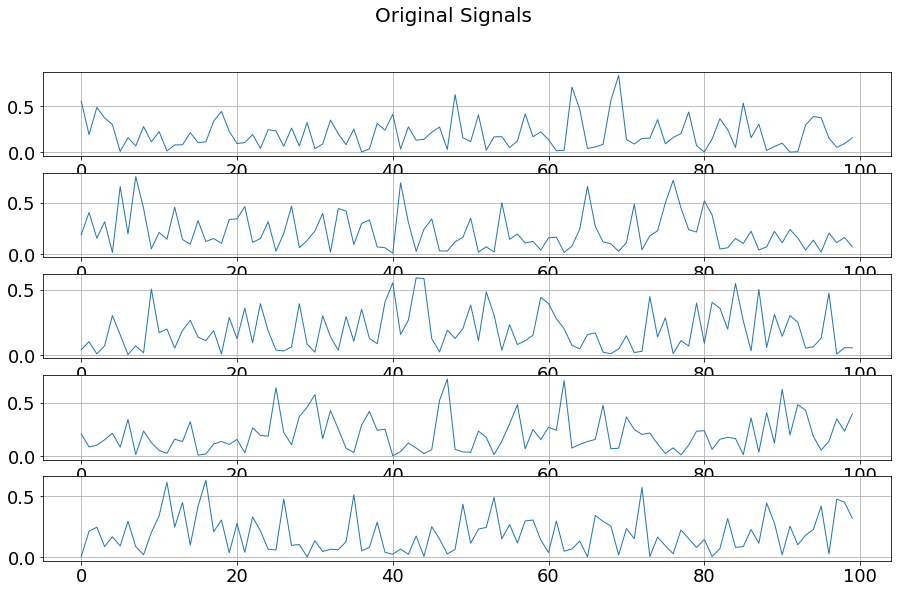

In [12]:
subplot_1D_signals(X = Y_.T[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)' ,figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X = S.T[0:100], title = 'Original Signals' ,figsize = (15.2,9), colorcode = None)

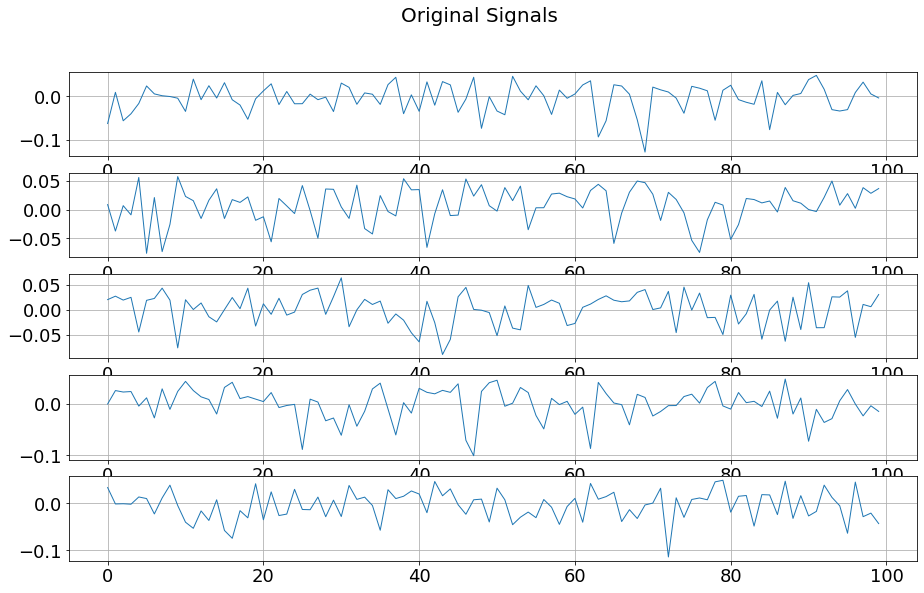

In [13]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T).T
Y_.shape, X.shape, S.shape
subplot_1D_signals(X = S.T[0:100] - Y_.T[0:100], title = 'Original Signals' ,figsize = (15.2,9), colorcode = None)

In [14]:
10*np.log10(np.mean((S.T)**2)/np.mean((S.T- Y_.T)**2))

18.241974858721623

In [15]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y_ = Wf @ X
Y_ = model.signed_and_permutation_corrected_sources(S.T,Y_.T)
# Y_ = Y_* (Y_ >= 0)
# Y_ = Y_ - np.mean(Y_ - S.T, axis = 0)
# Y_ = Y_ / Y_.sum(1).reshape(-1,1)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_
Y_ = ProjectColstoSimplex(Y_.T).T
print("Component SNR Values : {}\n".format(snr(S.T, Y_ - np.mean(Y_ - S.T, axis = 0))))

SINR = 10*np.log10(model.CalculateSINR(Y_.T, S)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [23.78609017 23.10602739 21.9610601  24.28749002 22.76754011]

Overall SINR : 26.214778124392485


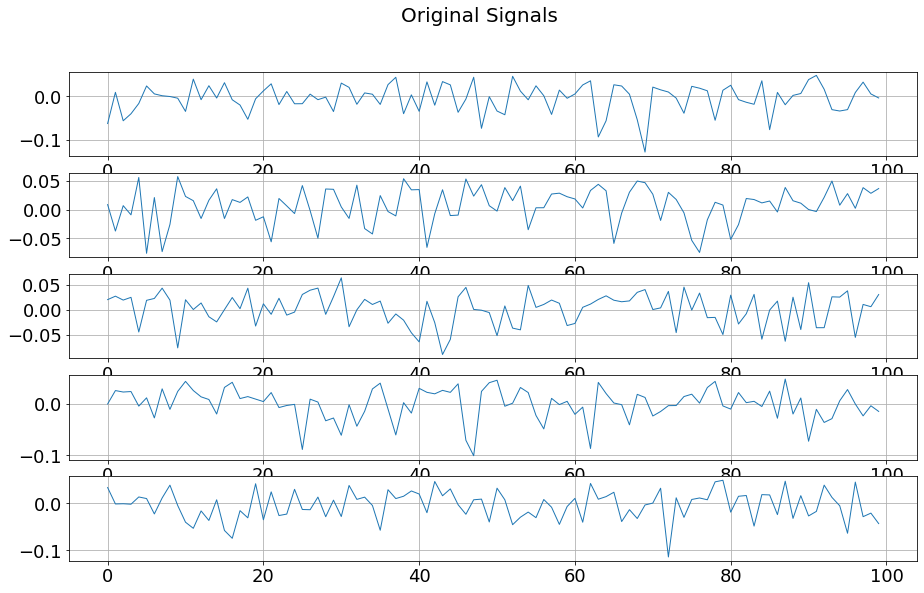

In [16]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T).T
Y_.shape, X.shape, S.shape
subplot_1D_signals(X = S.T[0:100] - Y_.T[0:100], title = 'Original Signals' ,figsize = (15.2,9), colorcode = None)

In [17]:
10*np.log10(np.mean((S.T)**2)/np.mean((S.T- Y_.T)**2))

18.241974858721623

In [18]:
import mir_eval

In [19]:
S.shape, Y_.T.shape

((5, 100000), (100000, 5))

In [20]:
mir_eval.separation.bss_eval_sources(S, Y_,
                     compute_permutation=True)

(array([26.54272176, 28.00027406, 24.07139764, 28.51637633, 22.91298523]),
 array([39.91276322, 37.43056992, 38.52240801, 38.68856779, 38.0422349 ]),
 array([26.7477959 , 28.52680588, 24.2307143 , 28.95582092, 23.04906463]),
 array([0, 1, 2, 3, 4]))